In [1]:
from itertools import combinations
import re
import optuna
# import shap  # !pip install shap  # error: subprocess-exited-with-error
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.multioutput import MultiOutputRegressor
from tqdm import tqdm
from data_manipulations import *

/home/tibo/.local/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_features = pl.read_parquet('train_features.parquet')
train_targets = pl.read_parquet('train_targets.parquet')
test_features = pl.read_parquet('test_features.parquet')
test_targets = pl.read_parquet('test_targets.parquet')

data = prepare_data_for_ml(
    train_features, train_targets, test_features, test_targets,
)

In [3]:
# def restrict(frame, heads=(25, 20)):
#     keys = frame.columns[:2]
#     temp = join_many((
#         frame.select(keys[0]).unique().sort(by=keys[0]).head(heads[0]),
#         frame.select(keys[1]).unique().sort(by=keys[1]).head(heads[1]),
#     ), how='cross')
#     return frame.join(temp, on=keys)

# train_features = restrict(train_features)
# train_targets = restrict(train_targets)
# test_features = restrict(test_features)
# test_targets = restrict(test_targets)

# data = prepare_data_for_ml(train_features, train_targets, test_features, test_targets)
# data['train_features_rect'].shape, data['train_targets_rect'].shape

# Exploration

In [4]:
%%time

n_trials = 50
progress_bar = tqdm(total=n_trials)

param_grid = {
    'learning_rate': ['float', 1e-4, 0.5, {'log': True}],  # 0.1
    'max_leaf_nodes': ['int', 2, 16, {}],  # 31
    'max_depth': ['int', 1, 5, {}],  # None
    'min_samples_leaf': ['int', 200, 1000, {}],  # 20
    'max_features': ['float', 0.75, 1, {'log': True}],  # 1.0
}

def get_cv_score(kwargs):
    model = MultiOutputRegressor(HistGradientBoostingRegressor(
        early_stopping=True,  # 'auto',
        scoring=scoring,  # 'loss',
        random_state=0, # None,
        **kwargs,
    ))
    return cross_val_score(
        model,
        data['train_features_rect'].to_numpy(),
        data['train_targets_rect'].to_numpy(),
        cv=5,
        scoring=scoring,
        n_jobs=-1,
    ).mean()

def objective(trial):
    kwargs = {
        key: getattr(trial, f'suggest_{typ}')(key, *bounds, **options)
        for key, (typ, *bounds, options) in param_grid.items()
    }
    score = get_cv_score(kwargs)
    progress_bar.update(1)
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=n_trials)

100%|██████████| 50/50 [04:40<00:00,  5.32s/it][I 2025-04-20 22:04:44,609] Trial 49 finished with value: 0.7291160925833845 and parameters: {'learning_rate': 0.4861230330745632, 'max_leaf_nodes': 12, 'max_depth': 2, 'min_samples_leaf': 412, 'max_features': 0.8246179446441831}. Best is trial 18 with value: 0.7378582248770547.


CPU times: user 1.8 s, sys: 516 ms, total: 2.32 s
Wall time: 4min 40s


In [5]:
prefix = r'^params_'
cv_results = pl.DataFrame(study.trials_dataframe())
cv_results = (
    cv_results
    .rename({
        col: re.sub(prefix, '', col)
        for col in cv_results.columns
    })
)

In [6]:
best = (
    cv_results
    .filter(pl.col('value') == pl.col('value').max())
    .select(*param_grid.keys(), 'value')
    .to_dicts()[0]
)
best

{'learning_rate': 0.26188335914857236,
 'max_leaf_nodes': 8,
 'max_depth': 1,
 'min_samples_leaf': 508,
 'max_features': 0.7921108721927567,
 'value': 0.7378582248770547}

In [8]:
best = {
    'learning_rate': 0.25,
    'max_leaf_nodes': 8,
    'max_depth': 1,
    'min_samples_leaf': 500,
    'max_features': 0.8,
}

# Stability, local grid search

In [9]:
param_grid = {
    'learning_rate': np.linspace(best['learning_rate'] * 0.8, best['learning_rate'] * 1.2, 5),
    'max_leaf_nodes': np.arange(max(best['max_leaf_nodes'] - 2, 2), best['max_leaf_nodes'] + 2),
    'max_depth': np.arange(max(best['max_depth'] - 2, 1), best['max_depth'] + 2),
    'min_samples_leaf': np.arange(max(best['min_samples_leaf'] - 10, 1), best['min_samples_leaf'] + 10, 4),
    'max_features': np.linspace(best['max_features'] * 0.8, best['max_features'] * 1.2, 5),
}

In [10]:
param_grid_local = pl.concat([
    join_many([
        pl.DataFrame(v_l, schema=[k_l]),
        pl.DataFrame(v_r, schema=[k_r]),
        pl.DataFrame(best).drop(k_l, k_r),
    ], how='cross').select(best.keys()).with_columns(group=pl.lit(ind))
    for ind, ((k_l, v_l), (k_r, v_r)) in enumerate(combinations(param_grid.items(), 2))
])
group_mapping = dict(enumerate(combinations(param_grid.keys(), 2)))

In [11]:
%%time

iterator = param_grid_local.drop('group').iter_rows(named=True)
scores = [get_cv_score(kwargs) for kwargs in tqdm(iterator, total=param_grid_local.height)]
cv_results = param_grid_local.with_columns(pl.Series(scores).alias('value'))


100%|██████████| 173/173 [16:38<00:00,  5.77s/it]

CPU times: user 3.94 s, sys: 1.27 s, total: 5.21 s
Wall time: 16min 38s


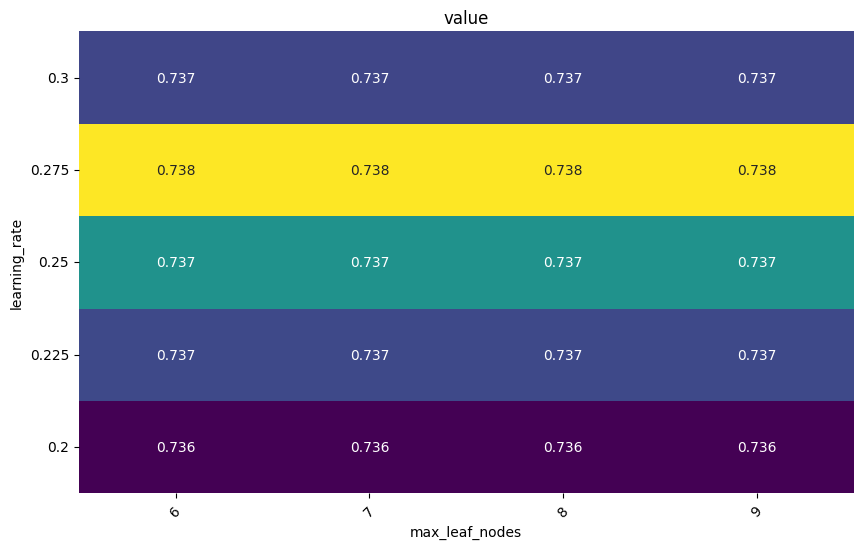

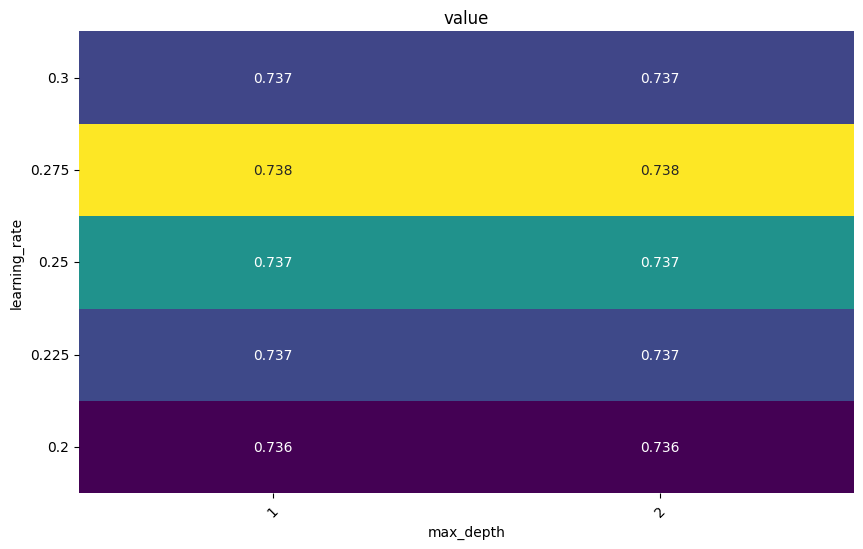

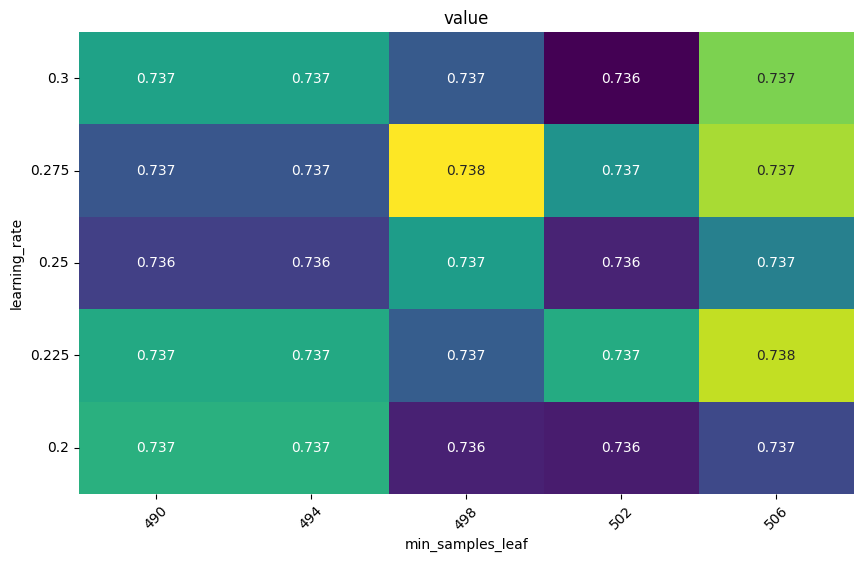

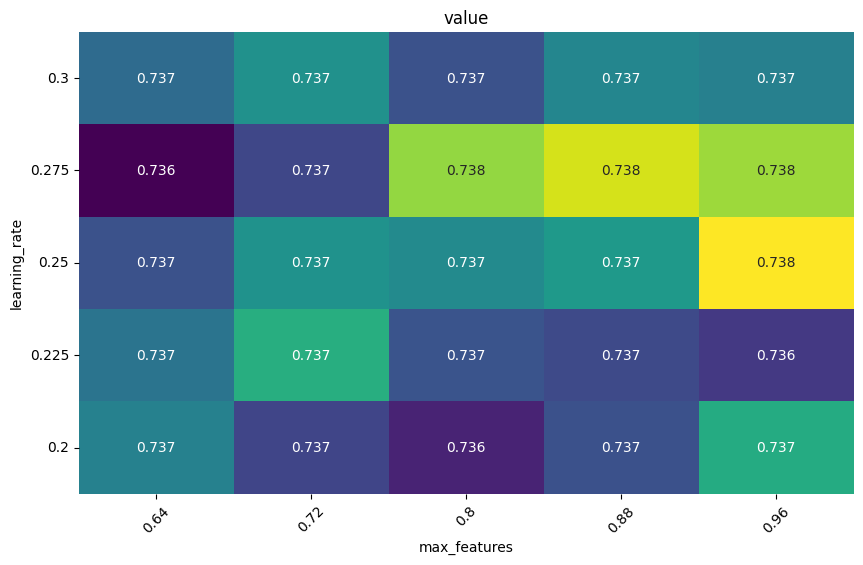

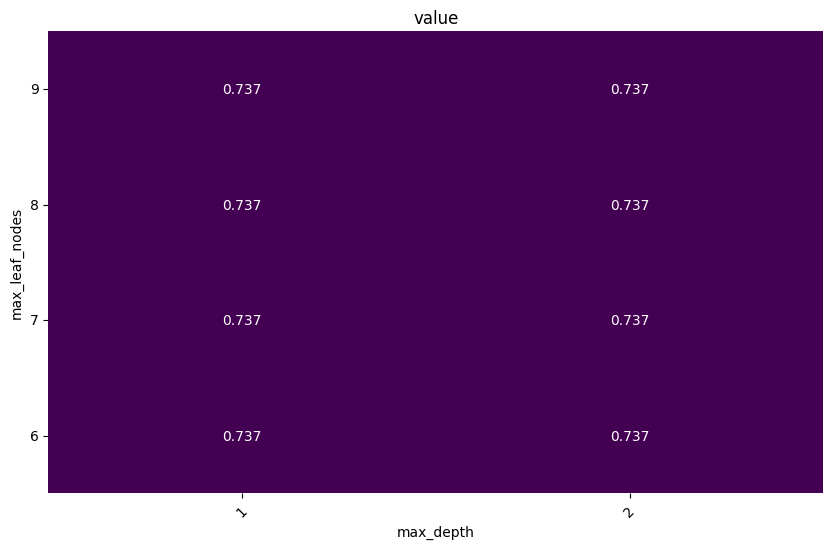

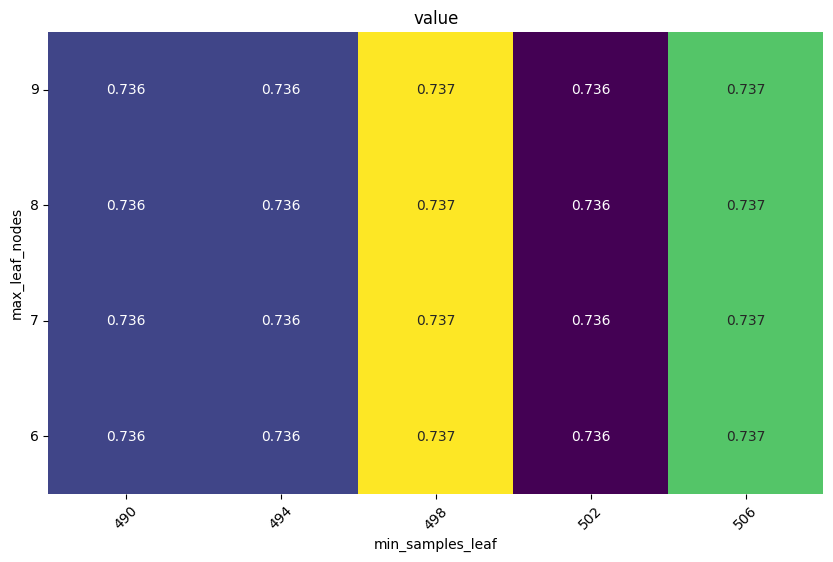

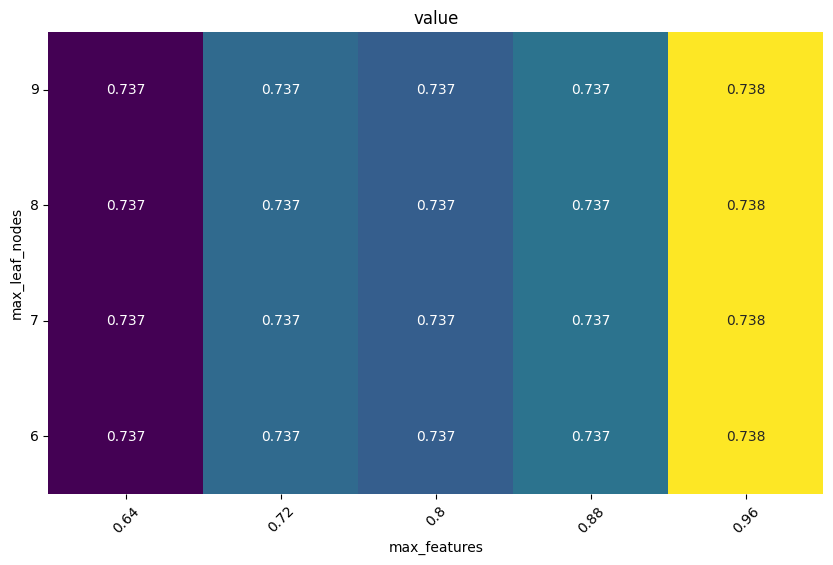

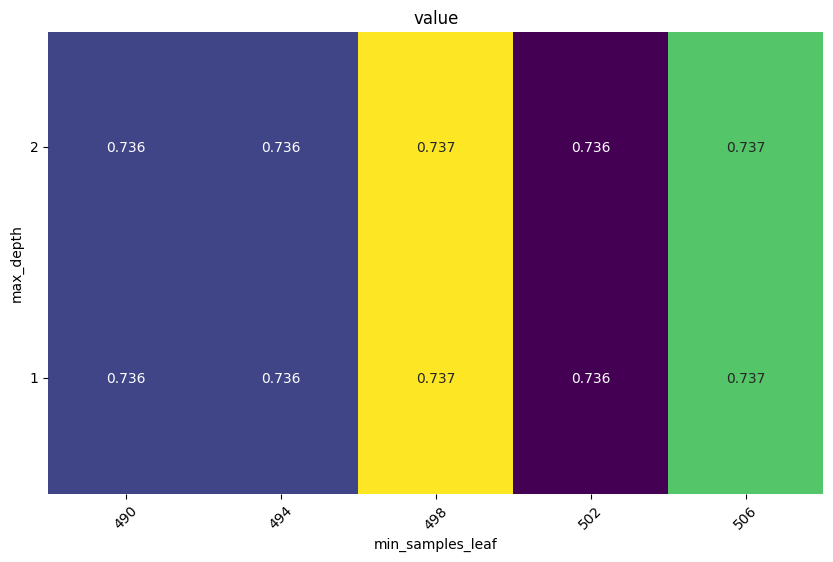

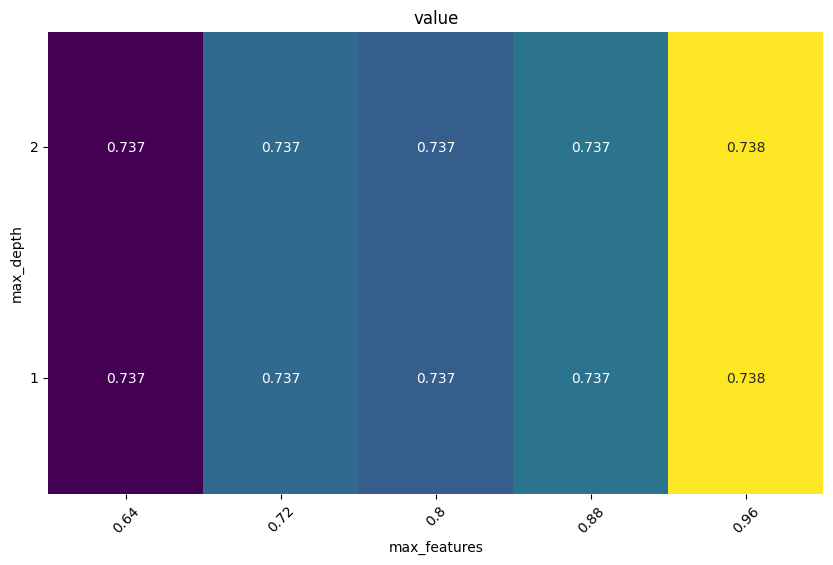

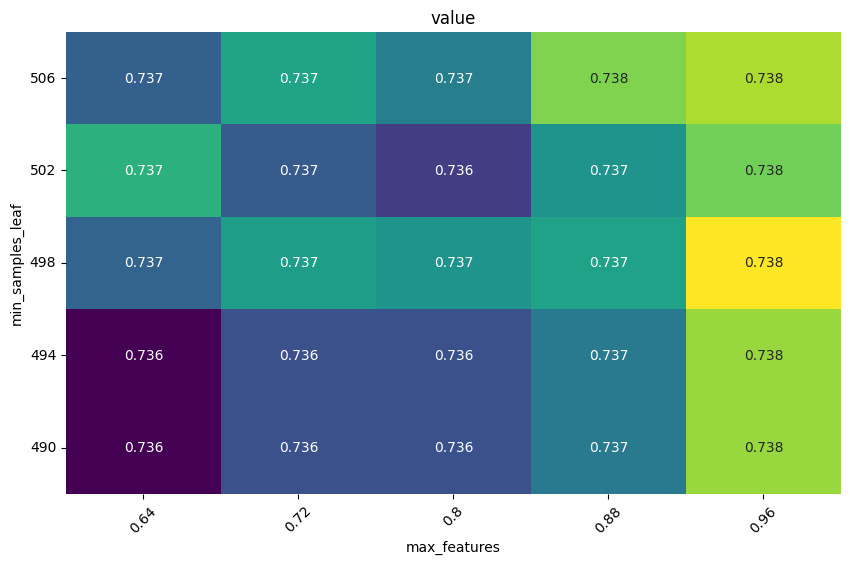

In [12]:
for group, part in cv_results.partition_by('group', include_key=False, as_dict=True).items():
    heatmap_part(part, group_mapping[group[0]], 'value')

In [13]:
(
    cv_results
    .filter(pl.col('value') == pl.col('value').max())
    .select(*param_grid.keys(), 'value')
    .to_dicts()
    [0]
)

{'learning_rate': 0.25,
 'max_leaf_nodes': 8,
 'max_depth': 1,
 'min_samples_leaf': 500,
 'max_features': 0.96,
 'value': 0.7379359258151672}

# Learning curve

In [14]:
model = MultiOutputRegressor(HistGradientBoostingRegressor(
    early_stopping=True,  # 'auto',
    scoring=scoring,  # 'loss',
    random_state=0, # None,
    **best,
))

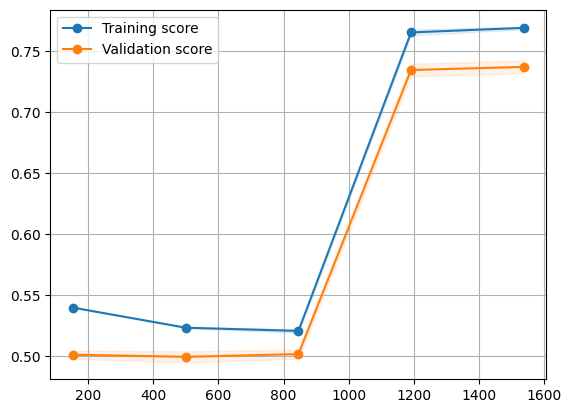

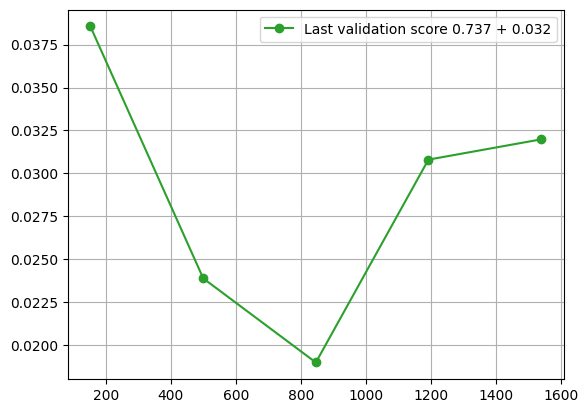

CPU times: user 278 ms, sys: 28.3 ms, total: 306 ms
Wall time: 16.6 s


In [15]:
%%time

train_sizes, train_scores, test_scores = learning_curve(
    model,
    data['train_features_rect'].to_numpy(),
    data['train_targets_rect'].to_numpy(),
    cv=5,
    scoring=scoring,
    n_jobs=-1,
)
plot_learning_curve(train_sizes, train_scores, test_scores)

# Score on test and feature importance

In [16]:
fitted_model, preds = fit_predict_sklearn_model(
    train_features, train_targets, test_features, test_targets,
    model,
)
join_truth_and_score(preds, data['test_days'], test_targets)

0.7326049622172129

In [ ]:
# for ind, estimator in enumerate(fitted_model.estimators_):
#     target = data['targets'][ind]
    
#     print(f'SHAP analysis for target {target}.')
#     explainer = shap.Explainer(estimator)
#     shap_values = explainer(data['test_features'].to_numpy())
    
#     shap.summary_plot(shap_values, data['test_features'].to_numpy())
#     plt.title(f'Summary plot for target {target}.')
#     plt.show()
    
#     shap.plots.bar(shap_values, show=False)
#     plt.title(f'Bar plot for target {target}.')
#     plt.show()
    
#     top_feature = (
#         data['test_features']
#         .columns[np.argmax(np.abs(shap_values.values).mean(axis=0))]
#     )
#     shap.plots.scatter(shap_values[:, top_feature], color=shap_values, show=False)
#     plt.title(f'Dependence plot for top feature {top_feature}, for target {target}.')
#     plt.show()
    
#     print(f'Force plot for the first test sample of {target}.')
#     display(shap.plots.force(shap_values[0], matplotlib=True))
    
#     print(f'Waterfall plot for the first test sample of {target}.')
#     shap.plots.waterfall(shap_values[0], show=False)
#     plt.title(f'SHAP Waterfall Plot - {target_name}.')
#     plt.show()
    
#     print(f'Decision plot for the first 50 test samples of {target}.')
#     shap.plots.decision(shap_values[:50], show=False)
#     plt.title(f'Decision plot for target {target}.')
#     plt.show()